This script aims to extract features out of raw ppg signal that would be useful in analysis of sleep stage of individuals.

AVppAmp	 -	Average of peak-to-peak amplitudes of the PPG signal.
SDppAmp  -	Standard deviation of peak-to-peak amplitudes, indicating variability.
SDSDppAmp  -	Successive differences in peak-to-peak amplitudes, showing variability across beats.
RMSSDppAmp  -	Root mean square of successive differences of peak-to-peak amplitudes, reflecting signal stability.
MaxppAmp  - Maximum peak-to-peak amplitude in the signal.
MinppAmp  - Minimum peak-to-peak amplitude in the signal.
MedianppAmp  - Median value of peak-to-peak amplitudes, showing central tendency.
SkewppAmp  -	Skewness of peak-to-peak amplitude distribution, indicating asymmetry.
KurtosisppAmp 	- Kurtosis of peak-to-peak amplitude distribution, reflecting the tailedness.
MADppAmp  -	Median absolute deviation of peak-to-peak amplitudes, measuring dispersion.
IQRppAmp  - Interquartile range of peak-to-peak amplitudes, capturing the spread of the middle 50% of values.
AVpw  - Average pulse width, indicating the typical width of the detected pulses.
SDpw  - Standard deviation of pulse widths, indicating variability in pulse duration.
SDSDpw  - Successive differences in pulse widths, showing variability across beats.
RMSSDpw	 -	Root mean square of successive differences in pulse widths, reflecting signal stability.
Maxpw  -	Maximum pulse width in the signal.
Minpw  -	Minimum pulse width in the signal.
Medianpw  - Median value of pulse widths, showing central tendency.
Skewpw  - Skewness of pulse width distribution, indicating asymmetry.
Kurtosispw  - Kurtosis of pulse width distribution, reflecting the tailedness.
MADpw  - Median absolute deviation of pulse widths, measuring dispersion.
IQRpw  - Interquartile range of pulse widths, capturing the spread of the middle 50% of values.
meanA1 	- Mean of the systolic area, representing the area under the curve during systole.
stdA1  - Standard deviation of systolic areas, indicating variability in systolic area sizes.
meanA2 - Mean of the diastolic area, representing the area under the curve during diastole.
stdA2 -	Standard deviation of diastolic areas, indicating variability in diastolic area sizes.
meanArea -	Mean of the total area under the PPG curve per pulse.
stdArea	- Standard deviation of total areas, indicating variability in overall signal area per pulse.
MeanIPAR -	Mean Inflection Point Area Ratio, comparing systolic to diastolic areas.
StdIPAR	- Standard deviation of the Inflection Point Area Ratio.
meanT1 - Mean of systolic times, indicating the average duration of systole.
stdT1 -	Standard deviation of systolic times, indicating variability in systole durations.
meanT2 - Mean of diastolic times, indicating the average duration of diastole.
stdT2 -	Standard deviation of diastolic times, indicating variability in diastole durations.
meanIPTR -	Mean Inflection Point Time Ratio, comparing systolic to diastolic times.
stdIPTR	 - Standard deviation of the Inflection Point Time Ratio.
HjorthActivity	-	Measure of signal variance (activity), reflecting the intensity of the signal.
HjorthMobility	-	Measure of the mean frequency, indicating the signal's rate of change.
HjorthComplexity  - Measure of the signal's complexity, indicating changes in frequency.
PoincareSD1	- Standard deviation perpendicular to the line of identity in Poincare plot, reflecting short-term variability.
PoincareSD2	- Standard deviation along the line of identity in Poincare plot, reflecting long-term variability.
HurstExp - Hurst exponent, indicating the tendency of a time series to either regress to the mean or cluster in a direction.
DFAAlpha - Detrended Fluctuation Analysis exponent, indicating the presence of fractal patterns in the signal.
LyapunovExp	- Lyapunov exponent, measuring the rate of divergence of close trajectories, indicating chaos in the system.
HFD	higuchi_fd - Higuchi fractal dimension, measuring the fractal nature of the signal.
HFD_cardio	-	Higuchi fractal dimension of the heart rate variability (PP intervals).
TotalPower	-	Total power of the frequency spectrum, indicating overall signal energy.
LFPower	- Low-frequency power, representing parasympathetic activity.
HFPower	- High-frequency power, representing sympathetic activity.
LFHFRatio -	Ratio of low-frequency to high-frequency power, indicating the balance between sympathetic and parasympathetic activity.

In [4]:
import numpy as np
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy.linalg import svd
from statsmodels.robust import mad
import nolds
from scipy.integrate import simps
import pandas as pd

# Load data
data = pd.read_csv("https://raw.githubusercontent.com/Jasper-Thanapal/Elderly_Wearable_Tech/main/Data%20Science/SleepDisorderPrediction/data/test8.csv", header=None)
data_1 = data[0][0:299]
ppg_signal = np.array([data_1]).flatten()

# Constants
sampling_rate = 100  # in Hz
epoch_duration = len(ppg_signal) / sampling_rate  # in seconds

# Find peaks (simulating pulse peaks)
peaks, _ = find_peaks(ppg_signal)
troughs, _ = find_peaks(-ppg_signal)

# Peak-to-peak intervals (in seconds)
pp_intervals = np.diff(peaks) / sampling_rate

# Feature calculation functions
def rms(x):
    """
    Calculate the root mean square (RMS) of a given array.
    
    Parameters:
    x (numpy.ndarray): Input array.

    Returns:
    float: Root mean square of the array.
    """
    return np.sqrt(np.mean(x**2))

def calculate_sdsd(x):
    """
    Calculate the standard deviation of successive differences (SDSD).
    
    Parameters:
    x (numpy.ndarray): Input array.

    Returns:
    float: Standard deviation of successive differences.
    """
    return np.std(np.diff(x))

def calculate_rmssd(x):
    """
    Calculate the root mean square of successive differences (RMSSD).
    
    Parameters:
    x (numpy.ndarray): Input array.

    Returns:
    float: Root mean square of successive differences.
    """
    return np.sqrt(np.mean(np.diff(x)**2))

def calculate_areas(signal, inflection_indices):
    """
    Calculate the systolic and diastolic areas using the Simpson's rule.
    
    Parameters:
    signal (numpy.ndarray): Input signal (e.g., PPG signal).
    inflection_indices (list): Indices of the inflection points.

    Returns:
    tuple: Systolic area and diastolic area.
    """
    area_sys = simps(signal[inflection_indices[:len(inflection_indices)//2]], dx=1/sampling_rate)
    area_dias = simps(signal[inflection_indices[len(inflection_indices)//2:]], dx=1/sampling_rate)
    return area_sys, area_dias

def calculate_pulse_width(peaks, troughs, sampling_rate):
    """
    Calculate pulse widths between peaks and corresponding troughs.
    
    Parameters:
    peaks (numpy.ndarray): Indices of the peaks.
    troughs (numpy.ndarray): Indices of the troughs.
    sampling_rate (int): Sampling rate in Hz.

    Returns:
    numpy.ndarray: Array of calculated pulse widths.
    """
    widths = []
    for i in range(len(peaks) - 1):
        if i < len(troughs) and peaks[i] < troughs[i]:
            widths.append((troughs[i] - peaks[i]) / sampling_rate)
    return np.array(widths)

def inflection_points(signal):
    """
    Identify inflection points in the signal where the slope changes direction.
    
    Parameters:
    signal (numpy.ndarray): Input signal (e.g., PPG signal).

    Returns:
    list: Indices of inflection points.
    """
    inflections = []
    for i in range(1, len(signal)-1):
        if (signal[i-1] < signal[i] > signal[i+1]) or (signal[i-1] > signal[i] < signal[i+1]):
            inflections.append(i)
    return inflections
    
def higuchi_fd(x, kmax):
    """
    Calculate the Higuchi Fractal Dimension (HFD) of a time series.
    
    Parameters:
    x (numpy.ndarray): Input time series.
    kmax (int): Maximum value of k (segment length).

    Returns:
    float: Higuchi Fractal Dimension.
    """
    N = len(x)
    Lk = np.zeros(kmax)

    for k in range(1, kmax + 1):
        Lm = np.zeros((k,))

        for m in range(0, k):
            Lmk = 0
            for i in range(1, int(np.floor((N - m) / k))):
                Lmk += abs(x[m + i * k] - x[m + (i - 1) * k])
            Lm[m] = (Lmk * (N - 1) / (k * np.floor((N - m) / k)))

        Lk[k - 1] = np.sum(Lm) / k

    # Perform linear regression to find the slope (fractal dimension)
    Lk_log = np.log(Lk)
    k_log = np.log(range(1, kmax + 1))
    higuchi, _ = np.polyfit(k_log, Lk_log, 1)

    return higuchi

# Feature extraction begins here
# Peak-to-Peak Features
av_pp_amp = np.mean(pp_intervals)
sd_pp_amp = np.std(pp_intervals)
sdsd_pp_amp = calculate_sdsd(pp_intervals)
rmssd_pp_amp = calculate_rmssd(pp_intervals)
max_pp_amp = np.max(pp_intervals)
min_pp_amp = np.min(pp_intervals)
median_pp_amp = np.median(pp_intervals)
skew_pp_amp = stats.skew(pp_intervals)
kurt_pp_amp = stats.kurtosis(pp_intervals)

# Pulse Width Features
pulse_widths = calculate_pulse_width(peaks, troughs, sampling_rate)
mean_pulse_width = np.mean(pulse_widths)
sd_pulse_width = np.std(pulse_widths)
sdsd_pw = calculate_sdsd(pulse_widths)
rmssd_pw = calculate_rmssd(pulse_widths)
max_pw = np.max(pulse_widths)
min_pw = np.min(pulse_widths)
median_pw = np.median(pulse_widths)
skew_pw = stats.skew(pulse_widths)
kurt_pw = stats.kurtosis(pulse_widths)

# Systolic and Diastolic Areas
inflection_indices = inflection_points(ppg_signal)
if len(inflection_indices) >= 2:
    area_sys, area_dias = calculate_areas(ppg_signal, inflection_indices)
    mean_area = (area_sys + area_dias) / 2
    std_area = np.std([area_sys, area_dias])
    meanIPAR = area_sys / area_dias
    stdIPAR = np.std(meanIPAR)
else:
    area_sys = area_dias = mean_area = std_area = np.nan

# Systolic and Diastolic Times
mean_t1 = np.mean(np.diff(peaks[:len(peaks)//2]) / sampling_rate)
std_t1 = np.std(np.diff(peaks[:len(peaks)//2]) / sampling_rate)
mean_t2 = np.mean(np.diff(peaks[len(peaks)//2:]) / sampling_rate)
std_t2 = np.std(np.diff(peaks[len(peaks)//2:]) / sampling_rate)

# Inflection Point Time Ratio (IPTR)
mean_iptr = mean_t1 / mean_t2 if mean_t2 != 0 else np.nan
std_iptr = std_t1 / std_t2 if std_t2 != 0 else np.nan

# Nonlinear Features
hjorth_activity = np.var(ppg_signal)
hjorth_mobility = np.sqrt(np.var(np.gradient(ppg_signal)) / hjorth_activity)
hjorth_complexity = np.sqrt(np.var(np.gradient(np.gradient(ppg_signal))) / np.var(np.gradient(ppg_signal)) / hjorth_mobility)

poincare_sd1 = np.std(np.diff(pp_intervals)) / np.sqrt(2)
poincare_sd2 = np.sqrt(2 * np.std(pp_intervals)**2 - poincare_sd1**2)

hurst_exp = nolds.hurst_rs(ppg_signal)
dfa_alpha = nolds.dfa(ppg_signal)
lyapunov_exp = nolds.lyap_r(ppg_signal, emb_dim=6)  # Embedding dimension 6

# Robust Statistical Features
mad_pp_amp = mad(pp_intervals)
mad_pw = mad(pulse_widths)
iqr_pp_amp = np.subtract(*np.percentile(pp_intervals, [75, 25]))
iqr_pw = np.subtract(*np.percentile(pulse_widths, [75, 25]))

# Frequency Domain Features (Using FFT)
fft_signal = np.fft.fft(ppg_signal)
fft_freqs = np.fft.fftfreq(len(ppg_signal), d=1/sampling_rate)
fft_amplitudes = np.abs(fft_signal)

total_power = np.sum(fft_amplitudes**2)
lf_band = np.logical_and(fft_freqs >= 0.04, fft_freqs < 0.15)
hf_band = np.logical_and(fft_freqs >= 0.15, fft_freqs < 0.4)
lf_power = np.sum(fft_amplitudes[lf_band]**2)
hf_power = np.sum(fft_amplitudes[hf_band]**2)
lf_hf_ratio = lf_power / hf_power if hf_power != 0 else np.nan

# Feature Dictionary 
features = {
    # Peak-to-Peak Features
    "AVppAmp": av_pp_amp, "SDppAmp": sd_pp_amp, "SDSDppAmp": sdsd_pp_amp, "RMSSDppAmp": rmssd_pp_amp,
    "MaxppAmp": max_pp_amp, "MinppAmp": min_pp_amp, "MedianppAmp": median_pp_amp, "SkewppAmp": skew_pp_amp, 
    "KurtosisppAmp": kurt_pp_amp, "MADppAmp": mad_pp_amp, "IQRppAmp": iqr_pp_amp,
    
    # Pulse Width Features
    "AVpw": mean_pulse_width, "SDpw": sd_pulse_width, "SDSDpw": sdsd_pw, "RMSSDpw": rmssd_pw,
    "Maxpw": max_pw, "Minpw": min_pw, "Medianpw": median_pw, "Skewpw": skew_pw, 
    "Kurtosispw": kurt_pw, "MADpw": mad_pw, "IQRpw": iqr_pw,
    
    # Systolic and Diastolic Area Features
    "meanA1": area_sys, "stdA1": np.std(area_sys), "meanA2": area_dias, "stdA2": np.std(area_dias),
    "meanArea": mean_area, "stdArea": std_area, "MeanIPAR":meanIPAR, "StdIPAR": stdIPAR,
    
    # Systolic and Diastolic Times
    "meanT1": mean_t1, "stdT1": std_t1, "meanT2": mean_t2, "stdT2": std_t2,
    
    # Inflection Point Time Ratio (IPTR)
    "meanIPTR": mean_iptr, "stdIPTR": std_iptr,
    
    # Nonlinear Features
    "HjorthActivity": hjorth_activity, "HjorthMobility": hjorth_mobility, "HjorthComplexity": hjorth_complexity,
    "PoincareSD1": poincare_sd1, "PoincareSD2": poincare_sd2, "HurstExp": hurst_exp, 
    "DFAAlpha": dfa_alpha, "LyapunovExp": lyapunov_exp, "HFD": higuchi_fd(ppg_signal, 5), "HFD_cardio" : higuchi_fd(pp_intervals, 5),
    
    # Frequency Domain Features
    "TotalPower": total_power, "LFPower": lf_power, "HFPower": hf_power, "LFHFRatio": lf_hf_ratio,
}


/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/nolds/measures.py:249: ComplexWarning: Casting complex values to real discards the imaginary part
  min_tsep = int((1.0 / mf))
/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/nolds/measures.py:253: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 74
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/nolds/measures.py:282: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 23
  warnings.warn(msg.format(lag), RuntimeWarning)


In [5]:
df = pd.DataFrame(features.items(), columns=["Feature", "Value"])
print(df)

             Feature         Value
0            AVppAmp  1.313636e-01
1            SDppAmp  6.426475e-02
2          SDSDppAmp  8.431665e-02
3         RMSSDppAmp  8.431799e-02
4           MaxppAmp  2.000000e-01
5           MinppAmp  2.000000e-02
6        MedianppAmp  1.600000e-01
7          SkewppAmp -9.324743e-01
8      KurtosisppAmp -9.447659e-01
9           MADppAmp  2.223903e-02
10          IQRppAmp  1.025000e-01
11              AVpw  3.818182e-02
12              SDpw  2.424053e-02
13            SDSDpw  3.927922e-02
14           RMSSDpw  3.927922e-02
15             Maxpw  8.000000e-02
16             Minpw  1.000000e-02
17          Medianpw  3.500000e-02
18            Skewpw  2.892631e-01
19        Kurtosispw -1.480461e+00
20             MADpw  3.706506e-02
21             IQRpw  4.000000e-02
22            meanA1  7.011307e+03
23             stdA1  0.000000e+00
24            meanA2  6.982580e+03
25             stdA2  0.000000e+00
26          meanArea  6.996943e+03
27           stdArea

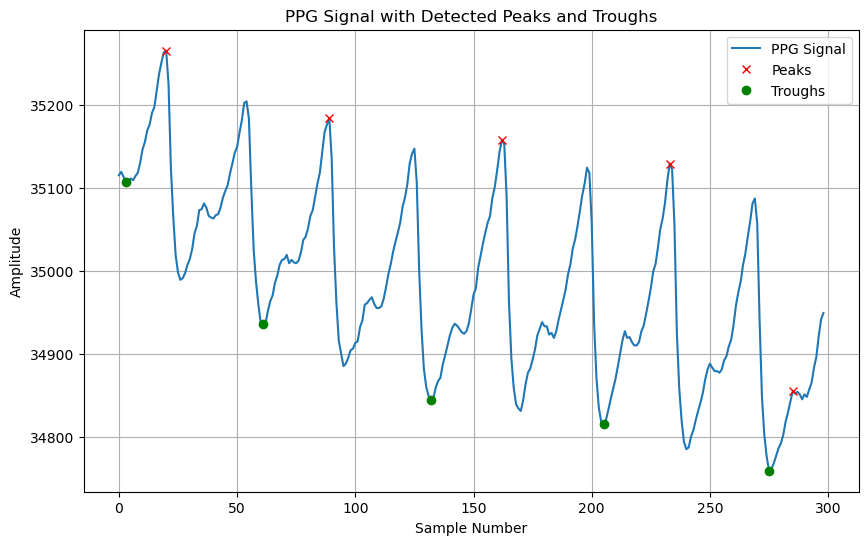

In [39]:
# Detect peaks 
peaks, _ = find_peaks(ppg_signal, distance=40)

# Detect troughs by inverting the signal
inverted_signal = -ppg_signal
troughs, _ = find_peaks(inverted_signal, distance=40)

# Plot the signal with peaks and troughs
plt.figure(figsize=(10, 6))
plt.plot(ppg_signal, label='PPG Signal')
# Plot peaks
plt.plot(peaks, ppg_signal[peaks], 'rx', label='Peaks')
# Plot troughs
plt.plot(troughs, ppg_signal[troughs], 'go', label='Troughs')

plt.title("PPG Signal with Detected Peaks and Troughs")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()
